# Project: Geometric Brownian Motion (GBM) Models and Stylized Facts
Geometric Brownian motion (GBM) is widely used as a pricing model. However, whether GBM replicates many of the statistical properties of actual pricing and return data is unclear. 
* These properties, referred to as _stylized facts_ have been observed for decades, dating back to early work by [Mandelbrot](https://en.wikipedia.org/wiki/Benoit_Mandelbrot) and later in several studies by [Rama Cont](http://rama.cont.perso.math.cnrs.fr/pdf/empirical.pdf) and more recently by [Ratliff-Crain et al.](https://arxiv.org/abs/2311.07738) who reviewed the 11 original stylized facts proposed by [Cont](http://rama.cont.perso.math.cnrs.fr/pdf/empirical.pdf) with newer data.

## Learning objectives
In this project, students will examine a few of the statistical properties (stylized facts) of return data and explore how well geometric Brownian motion models replicate these properties. 

* __Prerequisite__: Load and clean the historical dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) between `01-03-2018` and `12-29-2023`.
* __Task 1__: Does geometric Brownian motion replicate common stylized facts?
    * `TODO`: Compute the return distribution predicted by a GBM model analytical solution and Monte Carlo simulation
        * `Check`: Are the analytical and Monte Carlo returns drawn from the same distribution?
        * `Discussion`: how do our choices influence the results of comparison between analytical and numerical simulation of the returns?
    * `TODO`: Test the autocorrelation of GBM model returns and the returns computed from observed market prices

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* See the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) for additional information on functions and types used in this material.

In [3]:
include("Include.jl");

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `12-29-2023`, along with data for a few exchange-traded funds and volatility products during that time. 
* We load the `orignal_dataset` by calling the `MyMarketDataSet()` function and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ is stored in the `dataset` variable, where the dataset $\mathcal{D}$ has data for $\mathcal{L}$ firms, held in the `list_of_all_firms` variable.

In [5]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Then, get a list of firms that we have in the cleaned-up `dataset` and save it in the `list_of_all_firms` array (we sort these alphabetically):

In [11]:
list_of_all_firms = keys(dataset) |> collect |> sort;

Finally, we set some constant values that are used throughout the study. In particular, the value of $\Delta{t}$ holds the time step that we'll use (see below for a discussion of the value):

In [13]:
Δt = (1.0/252.0); # time step 1 x trading day

## Task 1: Does geometric Brownian motion replicate common stylized facts?
In this task, we explore whether or not a geometric Brownian motion (GBM) replicates common stylized facts. Previously, we showed that a GBM model could capture price information (or at least possible price ranges) depending on the firm and the time window selected. However, price is only one of the features we may be interested in. Let's see if a GBM model predicts the shape of the return distribution and the relationship between current and past returns, i.e., the [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) of the returns and the presence of volatility clustering. 

* First, let's select a ticker from the `list_of_all_firms::Array{String,2}` array and store your favorite ticker in the `my_favorite_ticker` variable:

In [15]:
my_favorite_ticker = "SPY"; # select a ticker

### Stylized Fact 1: Fat-tailed distributions from GBM?
Now that we have specified a ticker, let's compute the return distribution. From the analytical solution of the geometric Brownian motion (GBM) equation, we can see that GBM __will not admit Laplace distributed returns__, i.e., the returns will always follow a normal distribution. The return for a GBM model is given by:
$$
\begin{equation}
r_{t,\circ}\equiv \mu_{t,\circ}\cdot{\Delta{t}} = \ln\left(\frac{S_{t}}{S_{\circ}}\right) = \Biggl[\left(\mu-\frac{\sigma^{2}}{2}\right)\cdot\Delta{t} + (\sigma\sqrt{\Delta{t}})\cdot{Z_{t}(0,1)}\Biggr]
\end{equation}
$$
where $\Delta{t}=t - t_{\circ}$. This expression is a normal distribution with mean $\left(\mu-\frac{\sigma^{2}}{2}\right)\Delta{t}$ and variance $\sigma^{2}\Delta{t}$. Let's construct an analytical model for the annual return distribution for `my_favorite_ticker::String` for a single year, i.e., $\Delta{t} = 1$. In this scenario, $S_{\circ}$ would be the share price on the first trading day of the year, while $S_{t}$ is the share price on the last trading day of the year.
* Load the $(\hat{\mu},\hat{\sigma})$ dataset we computed previously [using `read(...)` method exported by the CSV.jl package](https://github.com/JuliaData/CSV.jl) and store this in the `parameters_df::DataFrame` variable. Next, we select the parameters for `my_favorite_ticker::String.` We'll store these in the `my_parameters` variable, which is type [DataFrameRow](https://dataframes.juliadata.org/stable/lib/types/#DataFrames.DataFrameRow).

In [104]:
parameters_df = CSV.read(joinpath(_PATH_TO_DATA,"Parameters-SP500-2018-2023-Backup.csv"), DataFrame); 
my_parameters = findfirst(x->x==my_favorite_ticker, parameters_df[:,:ticker]) |> i-> parameters_df[i,:] # find index of ticker |> grab the data in that row

Row,ticker,drift,volatility
,String7,Float64,Float64
377,SPY,0.100555,0.109962


#### Analytical return model
Construct an `analytical` model of the return for `my_favorite_ticker.` To select $(\hat{\mu},\hat{\sigma})$ values from a [DataFrameRow](https://dataframes.juliadata.org/stable/lib/types/#DataFrames.DataFrameRow), we simply pass in the column name as a [Symbol](https://docs.julialang.org/en/v1/manual/metaprogramming/#Symbols). Select the `drift` and `volatility` values:

In [19]:
μ̂ = my_parameters[:drift]; # drift parameter
σ̂ = my_parameters[:volatility]; # volatility parameter

Now construct an `analytical` return model by creating a Normal distribution with the proper mean and standard deviation using the [Normal function](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal) exported by the [Distributions.jl package](https://github.com/JuliaStats/Distributions.jl). Store this model in the `return_analytical_model` variable:

In [108]:
Δt = 5.0;
return_analytical_model = Normal((μ̂ - (σ̂^2)/2)*Δt ,σ̂*sqrt(Δt)); # this is for a single year Δt = 1, for multiple years change Δt

#### Monte-Carlo simulation
We could also construct the return distribution by sampling, using Monte-Carlo simulation and the geometric Brownian motion model. Assume we start on the first trading day of the year `20xx` and simulate until the end of `2023`. Get the actual data for `my_favorite_ticker` from the `dataset` using the [filter function from the DataFrame package](https://juliadatascience.io/filter_subset). 
* The selection condition we'll use is to find `:timestamps` after `Jan 01, 20xx`. Store this data in the `my_price_dataset::DataFrame` variable. This data will have `T` rows, the number of trading days between `20xx-01-01` and `2023-12-29`.

In [87]:
my_price_dataset = dataset[my_favorite_ticker] |> x-> filter(:timestamp => y -> y ≥ Date(2019,01,01), x)

Row,volume,volume_weighted_average_price,open,close,high,low,timestamp,number_of_transactions
,Float64,Float64,Float64,Float64,Float64,Float64,DateTime,Int64
1,1.25289e8,249.162,245.98,250.18,251.21,245.95,2019-01-02T05:00:00,603596
2,1.444e8,245.661,248.23,244.21,248.57,243.67,2019-01-03T05:00:00,698031
3,1.42784e8,250.45,247.59,252.39,253.11,247.17,2019-01-04T05:00:00,708717
4,1.03337e8,254.061,252.69,254.38,255.95,251.69,2019-01-07T05:00:00,449989
5,1.02877e8,255.854,256.82,256.77,257.31,254.0,2019-01-08T05:00:00,461967
6,9.51802e7,257.809,257.56,257.97,258.91,256.19,2019-01-09T05:00:00,438054
7,9.69861e7,257.817,256.26,258.88,259.16,255.5,2019-01-10T05:00:00,417174
8,7.40467e7,258.329,257.68,258.98,259.01,257.03,2019-01-11T05:00:00,298070
9,7.10947e7,257.75,256.86,257.4,258.3,256.41,2019-01-14T05:00:00,288739


Now build an instance of the [MyGeometricBrownianMotionEquityModel](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) using a [build function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}), where you pass in values for the $(\hat{\mu},\hat{\sigma})$ parameters as arguments to the [build function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}). Store this in the `model` variable:

In [26]:
model = build(MyGeometricBrownianMotionEquityModel, (
            μ = μ̂, σ = σ̂ ));

To simulate the GBM model, we need to specify the `number_of_samples`, i.e., the number of trajectories to compute, the initial share price `Sₒ`, the initial time `T₁`, the final time `T₂`. Pass these (along with your `model` instance) into the [sample function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyGeometricBrownianMotionEquityModel,%20NamedTuple}). 
* The [sample function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyGeometricBrownianMotionEquityModel,%20NamedTuple}) generates `number_of_samples` possible price trajectories from $T_{1}\rightarrow{T}_{2}$ using the GBM `model` instance. The simulation data is returned as an array, where the first column in the time and columns `2:end` hold simulated trajectories. Store this in the variable `X`

In [90]:
number_of_samples = 250; # how many different futures should we simulate
Sₒ = my_price_dataset[1, :volume_weighted_average_price];
T₁ = 0*Δt
T₂ = (nrow(my_price_dataset)-1)*Δt
X = VLQuantitativeFinancePackage.sample(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
    number_of_paths = number_of_samples);

In [29]:
X

1258×251 Matrix{Float64}:
 0.0         249.162  249.162  249.162  …  249.162  249.162  249.162  249.162
 0.00396825  249.201  250.076  250.648     248.314  248.897  249.12   248.823
 0.00793651  248.873  253.58   247.356     248.094  251.059  249.127  250.579
 0.0119048   246.665  253.171  247.246     250.649  249.122  249.88   250.638
 0.015873    246.177  257.484  247.689     248.868  248.404  250.311  252.432
 0.0198413   247.464  260.102  245.827  …  247.422  247.299  248.852  250.134
 0.0238095   249.194  263.546  245.577     250.017  248.951  251.876  248.813
 0.0277778   248.898  263.798  247.424     245.85   250.241  251.241  248.676
 0.031746    249.981  260.787  245.895     243.747  250.576  251.402  246.851
 0.0357143   250.542  261.262  247.368     241.995  250.795  249.44   242.723
 0.0396825   250.249  259.174  248.928  …  243.867  252.4    248.139  244.565
 0.0436508   253.182  257.639  246.181     246.784  252.418  247.942  245.686
 0.047619    251.576  259.097  246.959

Finally, from the simulation data `X,` let's compute the return $r_{t,t-1} = \ln\left(S_{t}/S_{t-1}\right)$ for each trajectory in `X` and store the `return_numerical_model::Array{Float64,1}` using the [push! function](https://docs.julialang.org/en/v1/base/collections/#Base.push!).
* Because we constructed the analytical distribution to simulate $\Delta{t}$ years, we need to compute the return for a year, that is, $(t-1)\rightarrow{t}$ will be the period of $\Delta{t}$ years. We can capture this by looking at the first and last trading day of the simulation across all trials. Thus, we iterate over the columns of `X,` and grab the first and last element of that column. Each column is a sample path, i.e., a potential future.

In [114]:
return_numerical_model = Array{Float64,1}()
for i ∈ 2:number_of_samples
    Sₒ = X[1,i];
    S₁ = X[end,i];
    r = log(S₁/Sₒ)
    push!(return_numerical_model,r)
end

`Unhide` the code block below to see how we visualized the `analytical` and `numerical` return distributions. 
* __Summary__: The Monte Carlo reconstruction of the annual return (red line) should converge to the analytical expression (blue line) as the `number_of_samples::Int64` increases. However, while that is interesting mathematically, it suggests that the GBM model will not admit a fat-tail return distribution.

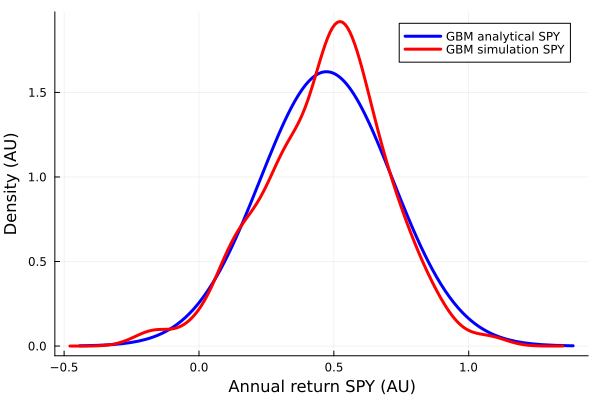

In [112]:
let
    plot(return_analytical_model, label="GBM analytical $(my_favorite_ticker)", lw=3, c=:blue)
    density!(return_numerical_model, label="GBM simulation $(my_favorite_ticker)",lw=3, c=:red)
    xlabel!("Annual return $(my_favorite_ticker) (AU)",fontsize=18)
    ylabel!("Density (AU)", fontsize=18)
end

#### Check: Are the analytical and Monte Carlo returns drawn from the same distribution?
GBM returns for firm $i$, whether calculated using the analytical solution or by Monte Carlo simulation, will always be Normally distributed. Thus, the analytical distribution model and the Monte Carlo approach should produce returns that appear to be from the _same distribution_. 

Let's develop an approach to explore this conjecture using the [One-sample Anderson Darling test](https://juliastats.org/HypothesisTests.jl/stable/nonparametric/#HypothesisTests.OneSampleADTest) exported by the [HypothesisTests.jl package](https://github.com/JuliaStats/HypothesisTests.jl).
* The `H0:null hypothesis` is that the returns from the analytical model and the Monte Carlo simulation are drawn from the _same distribution_. The `H1:alternative` hypothesis is that they are drawn from different distributions. We `reject H0` if `pvalue`$\leq$`p_value_cutoff.`

In [36]:
onesample_AD_test_result = OneSampleADTest(return_numerical_model, return_analytical_model)

One sample Anderson-Darling test
--------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.8946

Details:
    number of observations:   996
    sample mean:              0.09591034074903128
    sample SD:                0.10862103855773697
    A² statistic:             0.3519785699053625


#### Discussion questions
1. How the `number_of_samples` influence the agreement between the analytical return distribution and the return distribution created by Monte Carlo simulations?
2. How would you develop a procedure that compares the return distribution shape if we used the [K-sample Anderson-Darling test](https://juliastats.org/HypothesisTests.jl/stable/nonparametric/#HypothesisTests.KSampleADTest) instead of the [One-sample Anderson Darling test](https://juliastats.org/HypothesisTests.jl/stable/nonparametric/#HypothesisTests.OneSampleADTest)?

### Stylized Fact 2: Test the autocorrelation of GBM model returns
Another important stylized fact is the lack of autocorrelation of the returns. Let's compute the autocorrelation of the _daily_ returns from the data and compare that to the _daily_ autocorrelation computed using geometric Brownian motion.
* __Hypothesis__: Geometric Brownian motion is a random walk with drift. Thus, the autocorrelation of the returns computed from a GBM model should be close to zero. On the other hand, the actual return data for `my_favorite_ticker` should also follow a random walk, suggesting stock returns are random, an idea popularized by Malkiel in his book [A Random Walk Down Wall Street](https://en.wikipedia.org/wiki/A_Random_Walk_Down_Wall_Street).

Let's construct the _daily return_ from the simulation array `X` and store these values in the `daily_return_array_GBM` variable, where the `T-1` rows correspond to time, and the `number_of_samples` columns hold the return values $r_{t,t-1}$ where the time step is a single trading day.

In [39]:
daily_return_array_GBM = let
    daily_return_array_GBM = Array{Float64,2}(undef, nrow(my_price_dataset)-1, number_of_samples)
    for i ∈ 1:number_of_samples
        for k ∈ 2:nrow(my_price_dataset)
            Sₒ = X[k-1,i+1];
            S₁ = X[k,i+1];
            daily_return_array_GBM[k-1,i] = log(S₁/Sₒ);
        end
    end
    daily_return_array_GBM;
end;

* Next, we can compute the _daily return_ from the observed market data using [the `log_growth_matrix(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix). We store the data in the `daily_return_array_data` array, where `daily_return_array_data` has `T-1` rows and a single column: 

In [133]:
daily_return_array_data = log_growth_matrix(Dict(my_favorite_ticker=>my_price_dataset), 
    [my_favorite_ticker], testfirm=my_favorite_ticker, Δt = 1.0); # returns *return* data, notice Δt = 1.0

Finally, let's compute the [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) using the [autocor function](https://juliastats.org/StatsBase.jl/stable/signalcorr/#StatsBase.autocor) exported by the [StatsBase.jl package](https://github.com/JuliaStats/StatsBase.jl). 
* First, compute the length $L$ of the data, in this case `daily_return_array_data` which should be `L = T - 1`.
* Next, we compute the lag range and store this in the `τ` variable.
* Lastly, compute the autocorrelation for the GBM model returns (stored in the `AC_model` variable) and from the observed market price (stored in the `AC_data` variable).

In [43]:
L = length(daily_return_array_data);
τ  = range(0,step=1,stop=(L-1));
AC_model = autocor(daily_return_array_GBM[:,1], τ); # function provided by the StatsBase package
AC_data = autocor(daily_return_array_data, τ); # function provided by the StatsBase package

`Unhide` the code block below to see how we visualize the autocorrelation computed from the model and the prices observed in the market. 
* __Summary__: The observed (blue) and simulated (red) _daily returns_ show autocorrelation that is (for the most part) indistinguishable from zero at a 99\% CI. Thus, the GBM model does give returns that support the second stylized fact.

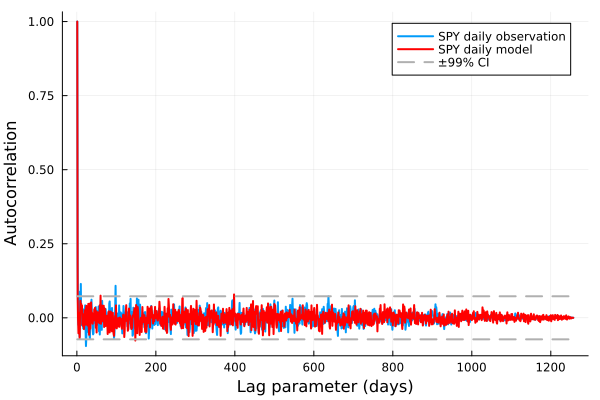

In [80]:
let
    Δ = 2.576/sqrt(L)
    plot(AC_data, lw=2, label="$(my_favorite_ticker) daily observation")
    plot!(AC_model, lw=2, c=:red,label="$(my_favorite_ticker) daily model")
    plot!(Δ*ones(L),lw=2,c=:gray69,ls=:dash, label="±99% CI")
    plot!(-Δ*ones(L),lw=2,c=:gray69,ls=:dash, label="")
    xlabel!("Lag parameter (days)",fontsize=18)
    ylabel!("Autocorrelation", fontsize=18)
end

### Stylized Fact 3: Test the volatility clustering of GBM model returns
Finally, let's consider volatility clustering. Volatility clustering is determined by examining the autocorrelation of the absolute return values for different lag values. In observed returns, we expect a positive absolute autocorrelation for short lags. Volatility clustering indicates that periods of high volatility, such as significant changes in returns, tend to occur close together in time.

#### Summary
`Unhide` the code block below to see how we computed and plotted the [autocorrelation function](https://en.wikipedia.org/wiki/Autocorrelation) for the absolute values of the simulated and observed _daily returns_.
* The observed dataset (blue line) shows positive autocorrelation for lags less than approximately `10 days` at a 99% confidence level. This suggests the market (or individual ticker) has a memory of approximately ten days or less following significant disruptions. On the other hand, the GBM model simulation (red line) does not show the positive absolute autocorrelation. Thus, GBM fails to show stylized fact 3.

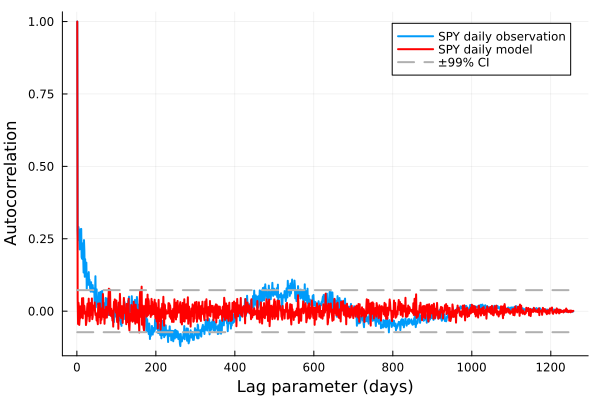

In [78]:
let
    Δ = 2.576/sqrt(L)
    VC_model = autocor(abs.(daily_return_array_GBM[:,1]), τ); # function provided by the StatsBase package
    VC_data = autocor(abs.(daily_return_array_data), τ); # function provided by the StatsBase package
    plot(VC_data, lw=2, label="$(my_favorite_ticker) daily observation")
    plot!(VC_model, lw=2, c=:red,label="$(my_favorite_ticker) daily model")
    plot!(Δ*ones(L),lw=2,c=:gray69,ls=:dash, label="±99% CI")
    plot!(-Δ*ones(L),lw=2,c=:gray69,ls=:dash, label="")
    xlabel!("Lag parameter (days)",fontsize=18)
    ylabel!("Autocorrelation", fontsize=18)
end

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.